## data loading

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # K邻近聚类
from sklearn.tree import DecisionTreeClassifier # 决策树分类
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score,precision_recall_curve
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit,cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import train_test_split,ShuffleSplit,learning_curve

import warnings
warnings.filterwarnings("ignore")
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')


### 前面計算出來的變量

In [3]:
DropFeature = ['service3_level','service1_cnt','service2_cnt','agreement1','verified']

In [4]:
numerical_fea = [
 'card_a_cnt',
 'card_b_cnt',
 'card_c_cnt',
 'op1_cnt',
 'op2_cnt',
 'card_d_cnt',
 'agreement_total',
 'service1_cnt',
 'service1_amt',
 'acc_count',
 'login_cnt_period1',
 'login_cnt_period2',
 'ip_cnt',
 'login_cnt_avg',
 'login_days_cnt',
 'product7_cnt',
 'product7_fail_cnt',
 'p_oneDayOpt',
 'p_7DayOpt',
 'p_15DayOpt',
 'p_oneDayOptIpType',
 'p_7DayOptIpType',
 'p_15DayOptIpType',
 'p_oneDayOptChanType',
 'p_7DayOptChanType',
 'p_15DayOptChanType',
 'AllMon_1',
 'AllMon_7',
 'AllMon_15',
 'AllMon_30',
 'Mean过去1天累计交易金额',
 'Std过去1天累计交易金额',
 'Max过去1天累计交易金额',
 'Min过去1天累计交易金额',
 'Mean过去30天累计交易金额',
 'Std过去30天累计交易金额',
 'Max过去30天累计交易金额',
 'Min过去30天累计交易金额',
 'Mean过去15天累计交易金额',
 'Std过去15天累计交易金额',
 'Max过去15天累计交易金额',
 'Min过去15天累计交易金额',
 'Mean过去7天累计交易金额',
 'Std过去7天累计交易金额',
 'Max过去7天累计交易金额',
 'Min过去7天累计交易金额',
 '过去1天累计交易次数',
 '过去7天累计交易次数',
 '过去15天累计交易次数',
 '过去30天累计交易次数',
 '过去7天平均交易次数',
 '过去15天平均交易次数',
 '过去30天平均交易次数',
 '过去30天交易平台类型',
 '过去1天交易超过1万元次数']

In [318]:
category_fea = ['age',
'using_time',
'sex',
 'provider',
 'level',
 'regist_type',
 'agreement2',
 'agreement3',
 'agreement4',
#  'province',
#  'city',
 'service3',
]

In [319]:
_LevelFea = [
 'balance',
 'balance_avg',
 'balance1',
 'balance1_avg',
 'balance2',
 'balance2_avg',
  'product1_amount',
 'product2_amount',
 'product3_amount',
 'product4_amount',
 'product5_amount',
 'product6_amount'
]

## 變量分佈分析

In [98]:
data_tr_1 = pd.read_csv('tr_fea_5.csv')
data_ts_1 = pd.read_csv('ts_fea_5.csv')

### 离散变量分析

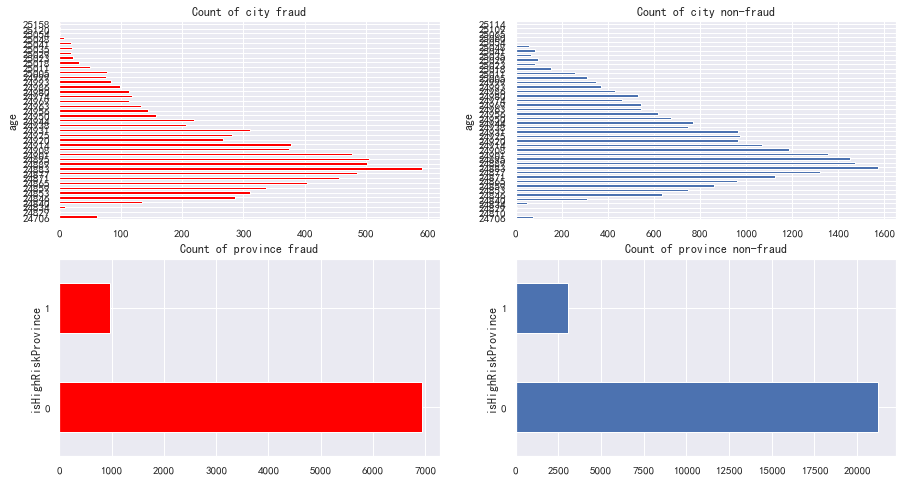

In [6]:
train_loan_fr = data_tr_1.loc[data_tr_1['label'] == 1]
train_loan_nofr = data_tr_1.loc[data_tr_1['label'] == 0]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 8))

train_loan_fr.groupby('age')['age'].count().plot(kind='barh', ax=ax1, color = 'red',title='Count of age fraud')
train_loan_nofr.groupby('age')['age'].count().plot(kind='barh', ax=ax2, title='Count of age non-fraud')

train_loan_fr.groupby('isHighRiskProvince')['isHighRiskProvince'].count().plot(kind='barh', ax=ax3,  color = 'red',title='Count of province fraud')
train_loan_nofr.groupby('isHighRiskProvince')['isHighRiskProvince'].count().plot(kind='barh', ax=ax4,title='Count of province non-fraud')

plt.show()

In [302]:
ageCountFraud = train_loan_fr.groupby('age').size().reset_index()
# ageCountFraud = sorted(ageCountFraud.items(), key = lambda x:(x[1], x[0]))

In [297]:
cityCountFraud = train_loan_fr.groupby('city').size().reset_index()
ProvinceCountFraud = train_loan_fr.groupby('province').size().reset_index()

In [303]:
ageCountFraud.describe()

,age,0
count,41.000000,41.000000
mean,24944.878049,192.439024
std,87.083062,176.154485
min,24706.000000,1.000000
25%,24883.000000,32.000000
50%,24944.000000,134.000000
75%,25005.000000,310.000000
max,25158.000000,590.000000


In [314]:
ageCountFraud[[0]].describe()

,0
count,41.000000
mean,192.439024
std,176.154485
min,1.000000
25%,32.000000
50%,134.000000
75%,310.000000
max,590.000000


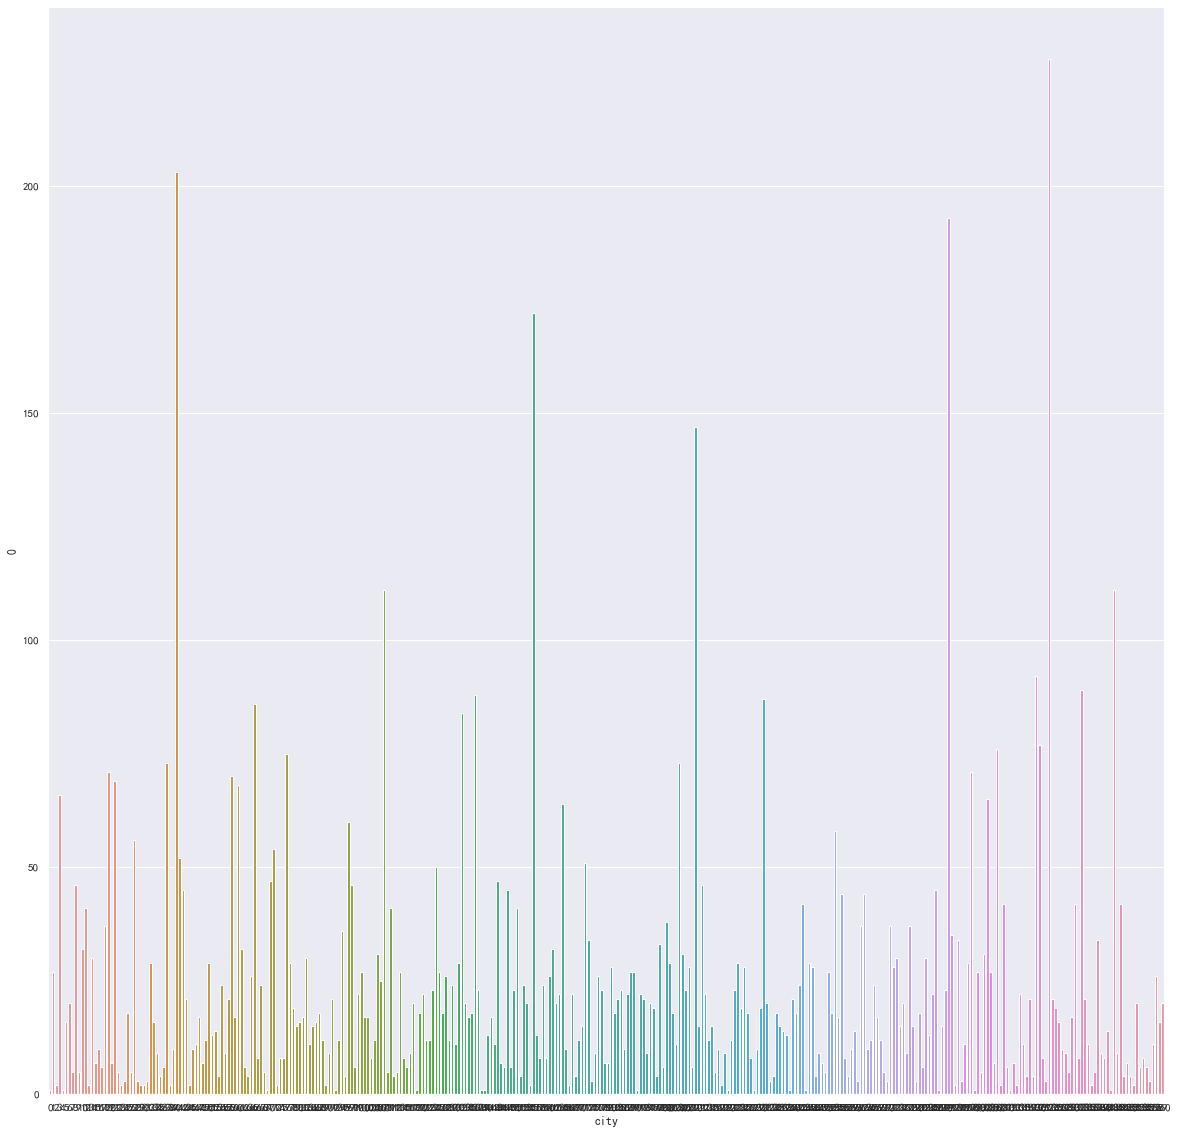

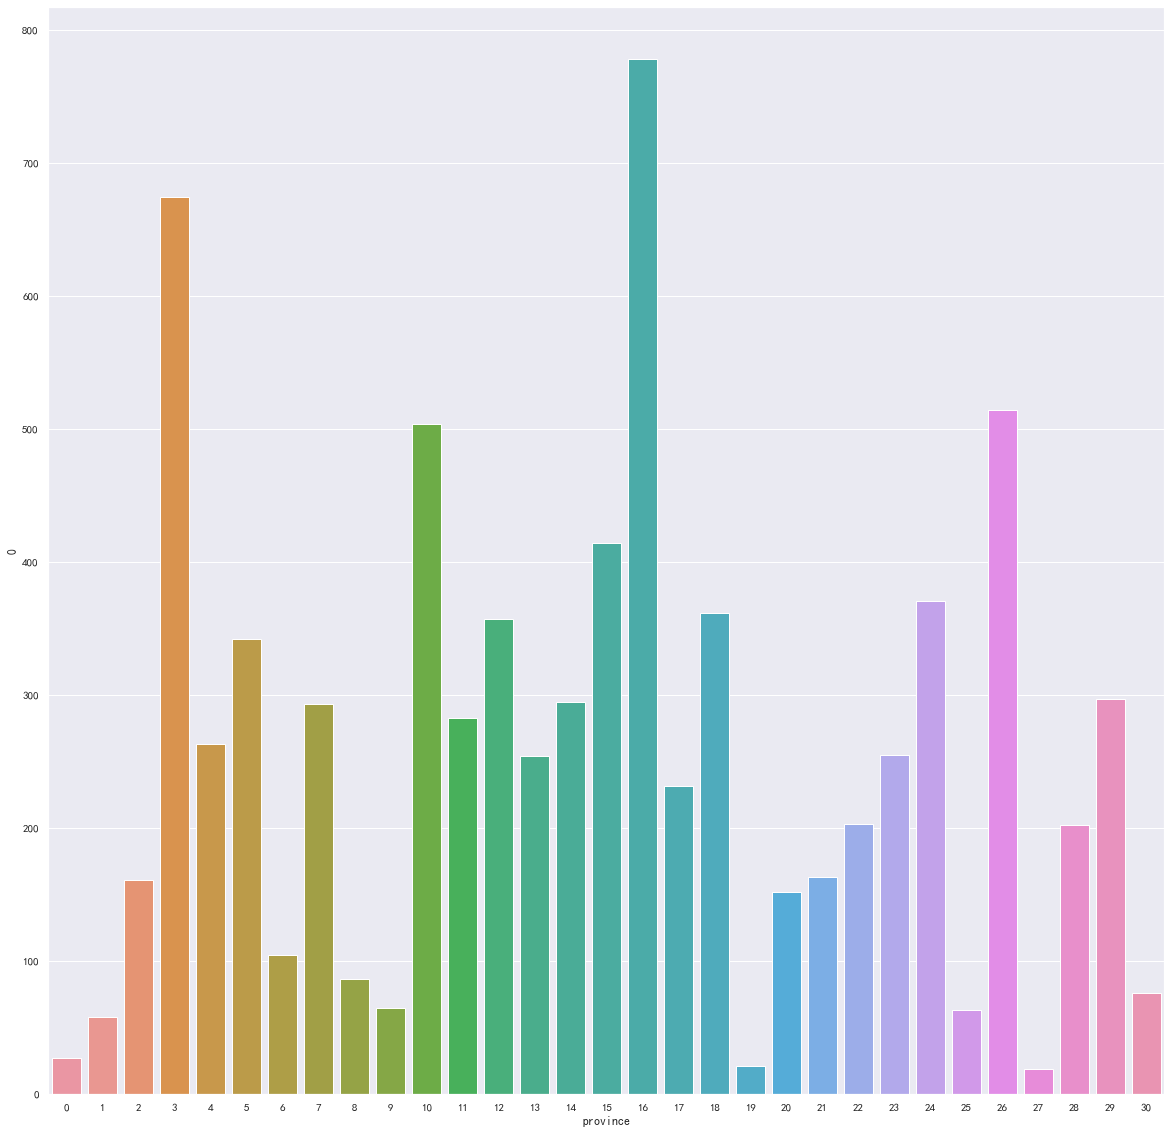

In [298]:
plt.figure(figsize=(20,20))
sns.barplot(cityCountFraud.iloc[:,0],
            cityCountFraud.iloc[:,1])
plt.savefig('cityCountFraud.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,20))
sns.barplot(ProvinceCountFraud.iloc[:,0],
            ProvinceCountFraud.iloc[:,1])
plt.savefig('ProvinceCountFraud.png',bbox_inches='tight')
plt.show()

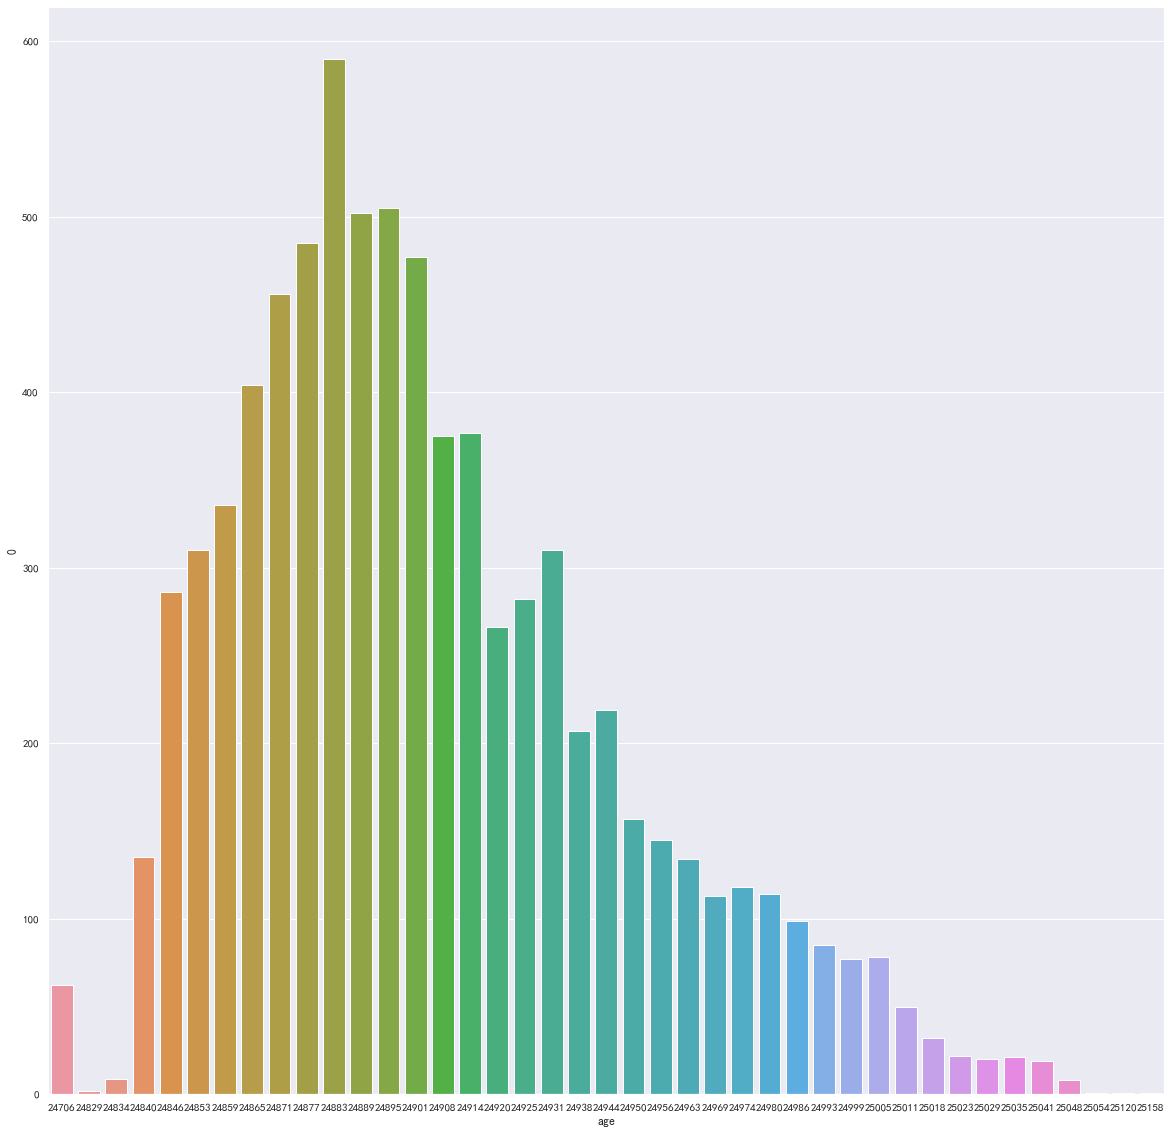

In [44]:
plt.figure(figsize=(20,20))
sns.barplot(ageCountFraud.iloc[:,0],
            ageCountFraud.iloc[:,1])
plt.savefig('ageCount.png',bbox_inches='tight')
plt.show()

### 连续变量分析

In [263]:
def draw_log(data_train,fea):
    #Ploting Transaction Amount Values Distribution
    plt.figure(figsize=(16,12))
    plt.suptitle('Transaction Values Distribution', fontsize=22)
    plt.subplot(221)
    sub_plot_1 = sns.distplot(data_train[fea])
    sub_plot_1.set_title(fea+" Distribuition", fontsize=18)
    sub_plot_1.set_xlabel("")
    sub_plot_1.set_ylabel("Probability", fontsize=15)

    plt.subplot(222)
    sub_plot_2 = sns.distplot(np.log(data_train[fea]+1))
    sub_plot_2.set_title(fea + " (Log) Distribuition", fontsize=18)
    sub_plot_2.set_xlabel("")
    sub_plot_2.set_ylabel("Probability", fontsize=15)
    # print("feature:",fea)
    # print("Kurtosis: %f" % np.log(data_train[fea]).kurt())
    # print("Skewness: %f" % np.log(data_train[fea]).skew())
    # print('=============')

    
    

In [ ]:
for fea in numerical_fea:
    draw_log(data_tr_1,fea)

### 箱型圖

In [55]:
def plot_box(bufenFea,i):
    plt.style.use("ggplot")
    # bufenFea = numerical_fea[20:25]
    bufenData = data_tr_1[bufenFea]
    fig = plt.figure(figsize = (15,9))
    plt.boxplot(x=bufenData.values,labels=bufenFea,whis=1.5)
    plt.savefig("%d.jpg"%(i),bbox_inches='tight')
    plt.show()


In [ ]:
j = 0
for i in range(0,len(numerical_fea),5):
    bufenFea = numerical_fea[i:i+5]
    plot_box(bufenFea,j)
    j+=1


### 分箱

In [40]:
import toad
from toad.plot import badrate_plot,bin_plot


combiner_1 = toad.transform.Combiner()
combiner_1.fit(data_tr_1,data_tr_1["label"],method='dt',exclude=["label","user"]+DropFeature+['city','province']+numerical_fea)# 分箱

bin_tr_1 = combiner_1.transform(data_tr_1) 

transer_1 = toad.transform.WOETransformer()
data_tr_woe_1 = transer_1.fit_transform(bin_tr_1, bin_tr_1["label"],exclude=["label","user"]+DropFeature+['city','province']+numerical_fea)
data_ts_woe_1 = transer_1.transform(combiner_1.transform(data_ts_1))

In [326]:
select_dev_1, drop_list_1=toad.selection.select(bin_tr_1,target = "label",empty = 0.7,iv = 0.02, corr =0.7, return_drop=True)
test_fea = list(select_dev_1.columns)
test_fea.remove('label')
selected_test_1 = data_ts_woe_1[test_fea]
selected_train_1 = data_tr_woe_1[select_dev_1.columns]

In [324]:
def sns_p(df,filename):
    dfData = df.corr()
    plt.subplots(figsize=(24, 20)) # 设置画面大小
    sns.heatmap(dfData, square=True, cmap="coolwarm_r",linewidths=.5,cbar_kws={"shrink": 0.82})
    if filename:
        plt.savefig(filename,bbox_inches='tight')
    plt.show()

In [ ]:
sns_p(selected_train_1,"初篩tr.png")

### 特征篩選

In [207]:
# 相關性篩選
# RFE遞歸篩選
# PSI值和KS值筛选特征？

features = [f for f in data_tr_woe_guiyi.columns if f not in ['user','label']+DropFeature+['city','province']]
x_train = data_tr_woe_guiyi[features]
x_test = data_ts_woe_guiyi[features]
y_train = data_tr_woe_guiyi['label']

from sklearn.feature_selection import VarianceThreshold
selector_var = VarianceThreshold(threshold=3).fit(x_train,y_train)
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest,SelectFromModel
# #参数k为选择的特征个数
from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

# selector_pr = SelectKBest(k=15).fit(x_train,y_train)

selector_lr = SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit(x_train,y_train)
x_train_1 = selector_lr.transform(x_train)
x_test_1 = selector_lr.transform(x_test)

selector_gb = SelectFromModel(GradientBoostingClassifier()).fit(train,target_train)

In [211]:
from sklearn.feature_selection import RFE

model=LogisticRegression()
rfe=RFE(estimator=model,n_features_to_select=13,step=1)
rfe.fit(data_tr_woe_guiyi.drop(["label","user"]+DropFeature+['city','province'],axis=1).values,data_tr_woe_guiyi["label"].values)

use_list_1=[]
orig_list=data_tr_woe_guiyi.drop(["label","user"]+DropFeature+['city','province'],axis=1).columns

for i in range(len(orig_list)):
    if rfe.support_[i] :
        use_list_1.append(orig_list[i])
# use_list_1+=["label"]

final_train_1 = data_tr_woe_guiyi[use_list_1+["label"]]
final_test_1 = data_tr_woe_guiyi[use_list_1]


In [219]:
df = data_tr_woe_guiyi

In [220]:

print('No Frauds', round(df['label'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['label'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop(['label','user']+DropFeature, axis=1)
y = df['label']

skf = StratifiedKFold(n_splits=2,random_state=None,shuffle=False)

# shuffle:
for train_index,test_index in skf.split(X,y):
    print("Train: ",train_index,"Test: ",test_index)
    original_Xtrain,original_Xtest = X.iloc[train_index],X.iloc[test_index]
    original_ytrain,original_ytest = y.iloc[train_index],y.iloc[test_index]

original_train = pd.concat([original_Xtrain,original_ytrain],axis=1)
original_test = pd.concat([original_Xtest,original_ytest],axis=1)


original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values


No Frauds 75.46 % of the dataset
Frauds 24.54 % of the dataset
Train:  [16020 16028 16030 ... 32154 32155 32156] Test:  [    0     1     2 ... 16091 16092 16093]
Train:  [    0     1     2 ... 16091 16092 16093] Test:  [16020 16028 16030 ... 32154 32155 32156]


In [221]:
from imblearn.over_sampling import SVMSMOTE,SMOTE,BorderlineSMOTE
from collections import  Counter

class imbalancedData():
    def __init__(self,train,test,mmin,mmax,flag,lis=[]):
        self.flag = flag
        self.train_x = train.drop([flag]+lis,axis=1)
        self.train_y = train[flag]
        print('Original dataset shape %s' % Counter(self.train_y))
        self.test_x = test.drop([flag]+lis,axis=1)
        self.test_y = test[flag]
        self.columns = list(self.train_x.columns)
        self.keep = self.columns + [self.flag]
        self.mmin = 0.1 #低分段错分比例
        self.mmax = 0.7 # 高分段错分比例
    """
    0.1:噪声权重
    1:正常样本权重
    """
    def weight(self,x,y):
        if x==0 and y<self.mmin:
            return 0.1
        elif x==1 and y>self.mmax:
            return 0.1
        else:
            return 1
    def lgb_test(self):
        clf = lgb.LGBMClassifier(boosting_type='gbdt',
        objective = 'binary',
        metric = 'auc',
        learning_rate = 0.1,
        n_estimators=24,
        max_depth=4,
        num_leaves=25,
        max_bin = 40,
        min_data_in_leaf = 5,
        bagging_fraction=0.6,
        bagging_freq = 0,
        feature_fraction=0.8)
        clf.fit(self.train_x, self.train_y, eval_set = [(self.train_x,self.train_y),(self.test_x,self.test_y)]
        ,eval_metric = 'auc')
        return clf,clf.best_score_['valid_1']['auc']

    def data_cleaning(self):
        lgb_model,lgb_auc = self.lgb_test()
        sample = self.train_x.copy()
        sample[self.flag] = self.train_y
        
        sample['pred'] = lgb_model.predict_proba(self.train_x)[:,1]

        sample = sample.sort_values(by = ['pred'], ascending= False).reset_index()
        sample['rank'] = np.array(sample.index)/len(sample)

        sample['weight'] = sample.apply(lambda s:self.weight(s[self.flag],s['rank']),axis=1)
        osvp_sample = sample[sample.weight == 1][self.keep]
        osnu_sample = sample[sample.weight < 1][self.keep]

        train_x_osvp = osvp_sample[self.columns]
        train_y_osvp = osvp_sample[self.flag]

        return train_x_osvp,train_y_osvp,osnu_sample
    
    def smote(self,train_x_osvp,train_y_osvp,m=4,K=15,random_state=42):
        # smote = SVMSMOTE(k_neighbors=K,m_neighbors=m,
        # n_jobs = 1,out_step='deprecated', random_state=random_state,
        # svm_estimator='deprecated')
        
        # smote = SMOTE(random_state=random_state, k_neighbors=K,n_jobs=None)

        smote = BorderlineSMOTE(k_neighbors=K,m_neighbors=m,
        n_jobs = 1, random_state=random_state)
        
        rex,rey = smote.fit_resample(train_x_osvp,train_y_osvp)

        return rex,rey

    def apply_smote(self):
        train_x_osvp,train_y_osvp ,osnu_sample = self.data_cleaning()
        rex,rey = self.smote(train_x_osvp,train_y_osvp)
        print('Resampled dataset shape %s' % Counter(rey))
        print('badpctn:',rey.sum()/len(rey))
        df_rex = pd.DataFrame(rex)
        df_rex.columns = self.columns
        df_rex['weight'] = 1
        df_rex[self.flag] = rey
        df_aff_ovsp = df_rex.append(osnu_sample)
        return df_aff_ovsp
        

     

In [222]:
df_aff_ovsp = imbalancedData(train=original_train,test=original_test,mmin=0.3,mmax=0.7,flag = 'label',lis=[]).apply_smote()

Original dataset shape Counter({0: 12134, 1: 3945})
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[1]	training's auc: 0.64755	valid_1's auc: 0.63485
[2]	training's auc: 0.676497	valid_1's auc: 0.659792
[3]	training's auc: 0.688372	valid_1's auc: 0.668038
[4]	training's auc: 0.693568	valid_1's auc: 0.670883
[5]	training's auc: 0.695395	valid_1's auc: 0.671238
[6]	training's auc: 0.700257	valid_1's auc: 0.676983
[7]	training's auc: 0.703022	valid_1's auc: 0.677305
[8]	training's auc: 0.705113	valid_1's auc: 0.678678
[9]	training's auc: 0.706547	valid_1's auc: 0.679771
[10]

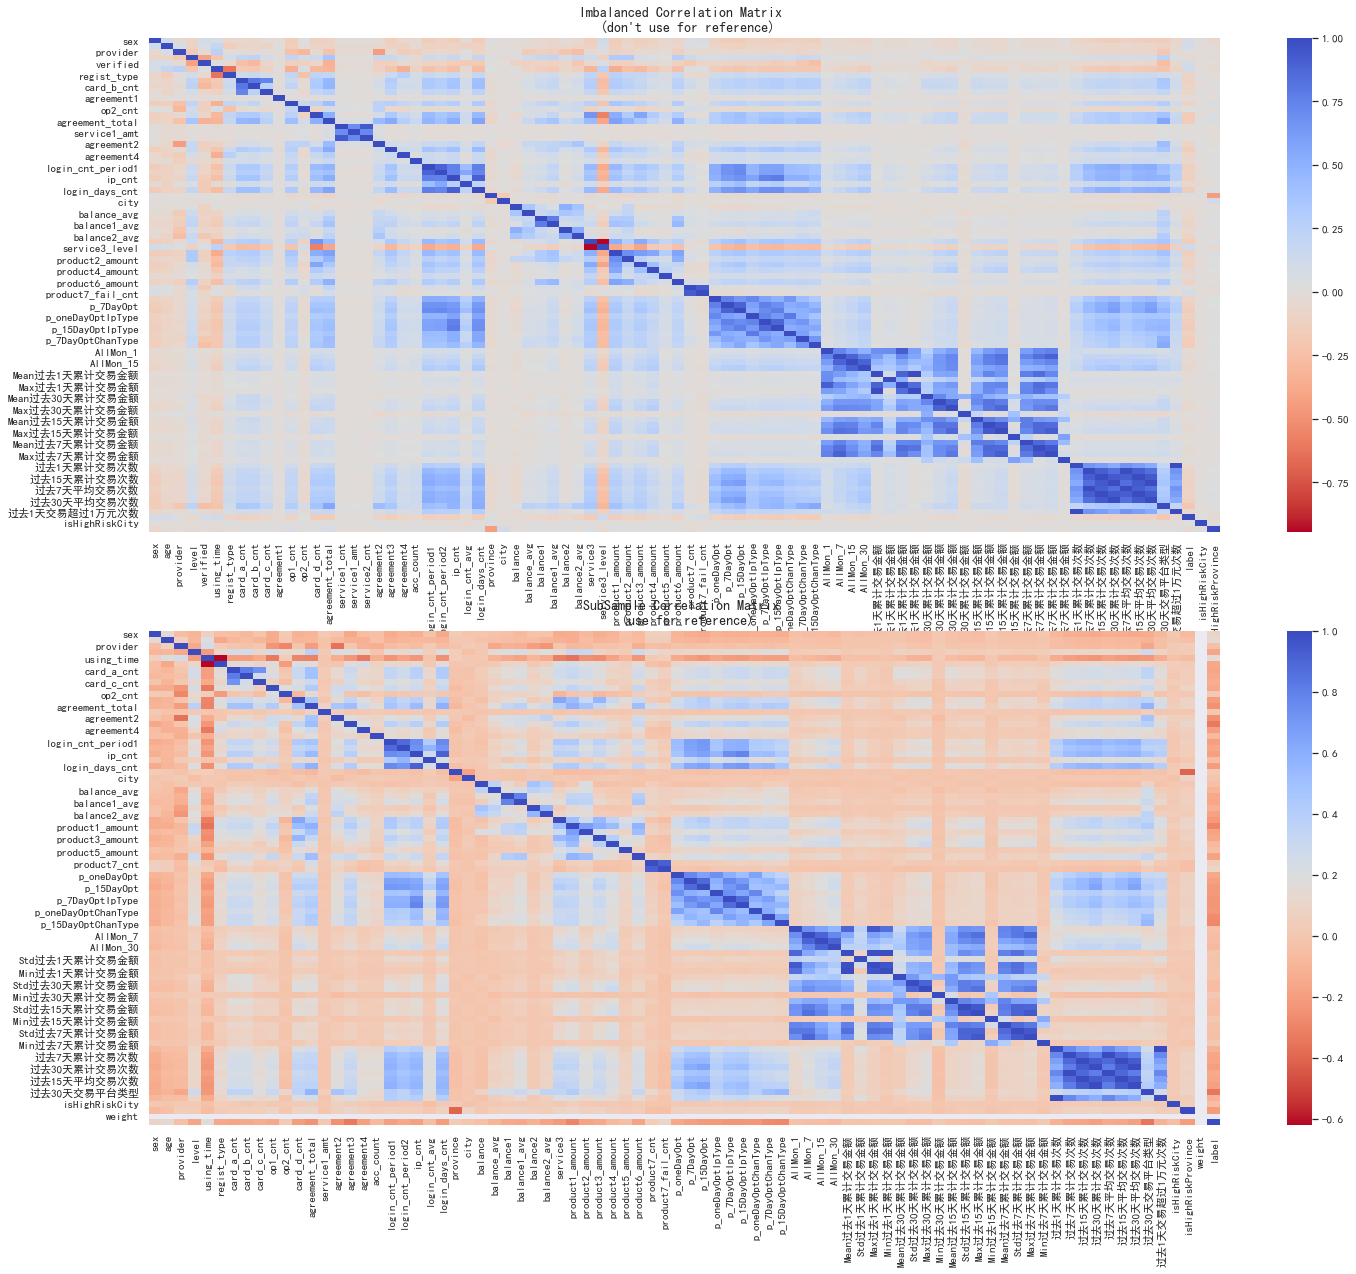

In [223]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# 整个样本相关性展示
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

#子样本相关性展示
sub_sample_corr = df_aff_ovsp.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

### 归一化

In [111]:
# 哪些变量需要归一化 -- 
Mon_Fea = ['AllMon_1',
 'AllMon_7',
 'AllMon_15',
 'AllMon_30',
 'Mean过去1天累计交易金额',
 'Std过去1天累计交易金额',
 'Max过去1天累计交易金额',
 'Min过去1天累计交易金额',
 'Mean过去30天累计交易金额',
 'Std过去30天累计交易金额',
 'Max过去30天累计交易金额',
 'Min过去30天累计交易金额',
 'Mean过去15天累计交易金额',
 'Std过去15天累计交易金额',
 'Max过去15天累计交易金额',
 'Min过去15天累计交易金额',
 'Mean过去7天累计交易金额',
 'Std过去7天累计交易金额',
 'Max过去7天累计交易金额',
 'Min过去7天累计交易金额']

In [112]:
# 特征归一化
data_tr_guiyi = data_tr_1
data_ts_guiyi = data_ts_1

rob_scaler = RobustScaler()

# df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

for fea in Mon_Fea:
    data_tr_guiyi[fea] = rob_scaler.fit_transform(data_tr_guiyi[fea].values.reshape(-1,1))
    data_ts_guiyi[fea] = rob_scaler.fit_transform(data_ts_guiyi[fea].values.reshape(-1,1))
    
    # data_tr_2[fea] = ((data_tr_2[fea] - np.min(data_tr_2[fea])) / (np.max(data_tr_2[fea]) - np.min(data_tr_2[fea])))
    # data_ts_2[fea] = ((data_ts_2[fea] - np.min(data_ts_2[fea])) / (np.max(data_ts_2[fea]) - np.min(data_ts_2[fea])))

### 單個模型訓練

### GBDT模型

train_ks: 0.04060165295099059


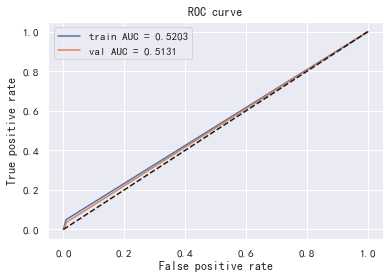

In [196]:
features = [f for f in data_tr_woe_guiyi.columns if f not in ['user','label']+DropFeature+['city','province']]
x_train = data_tr_woe_guiyi[features]
x_test = data_ts_woe_guiyi[features]
y_train = data_tr_woe_guiyi['label']

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=1000)
# train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
# valid_matrix = lgb.Dataset(x_val, label=y_val)

from sklearn.ensemble import GradientBoostingClassifier

"""使用训练集数据进行模型训练"""
gbdt_model = GradientBoostingClassifier(random_state=11)
gbdt_model.fit(x_train_split,y_train_split)

dev_pre = gbdt_model.predict(x_train_split)
val_pre = gbdt_model.predict(x_val)

plot_ROC_AUC(dev_pre,val_pre)

### lgb模型訓練

In [ ]:
f = pd.melt(data_tr_woe_guiyi, value_vars=numerical_fea)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

In [343]:
data_tr_nu = data_tr_1
data_ts_nu = data_ts_1

combiner_1 = toad.transform.Combiner()
combiner_1.fit(data_tr_nu,data_tr_nu["label"],method='dt',exclude=["label","user"]+DropFeature)# 等频分箱

bin_tr_1 = combiner_1.transform(data_tr_nu) 

transer_1 = toad.transform.WOETransformer()
data_tr_woe_1 = transer_1.fit_transform(bin_tr_1, bin_tr_1["label"],exclude=["label","user"]+DropFeature)
data_ts_woe_1 = transer_1.transform(combiner_1.transform(data_ts_1))


In [438]:
features = [f for f in df_aff_ovsp.columns if f not in ['user','label']+DropFeature]
x_train = df_aff_ovsp[features]
x_test = original_Xtest
y_train = df_aff_ovsp['label']

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2)

train_matrix = lgb.Dataset(x_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(x_val, label=y_val)

params = {
        # 'boosting_type': 'gbdt',
        # 'objective': 'binary',
        # 'metric': 'auc',
        # 'learning_rate': 0.01,
        # 'num_leaves': 95,
        # 'max_depth': 3,
        # 'min_data_in_leaf': 43,
        # 'min_child_weight':9.5,
        # 'bagging_fraction': 0.98,
        # 'feature_fraction': 0.96,
        # 'bagging_freq': 42,
        # 'reg_lambda': 8,
        # 'reg_alpha': 4,
        # 'min_split_gain': 0.25,
        # 'nthread': 8,
        # 'seed': 2020,
        # 'silent': True,
        # 'verbose': -1,

        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': 132,
        'max_depth': 5,
        'min_data_in_leaf': 16,
        'min_child_weight':9.4,
        'bagging_fraction': 0.73,
        'feature_fraction': 0.52,
        'bagging_freq': 25,
        'reg_lambda': 9,
        'reg_alpha': 8,
        'min_split_gain': 0.25,
        'nthread': 8,
        'seed': 2020,
        'silent': True,
        'verbose': -1,
}

"""使用训练集数据进行模型训练"""
lgb_model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=200, early_stopping_rounds=200)

dev_pre = lgb_model.predict(x_train_split, num_iteration=lgb_model.best_iteration)
val_pre = lgb_model.predict(x_val, num_iteration=lgb_model.best_iteration)
# plot_ROC_AUC(dev_pre,val_pre,"./pic/lgb-WOE-dt分箱.png")

# from sklearn.linear_model import LogisticRegression
# onehot = OneHotEncoder()

# X_train_leaves = onehot.fit_transform(lgb_model.predict(x_train_split, pred_leaf=True))

# lgbm_lr = LogisticRegression()
# lgbm_lr.fit(X_train_leaves, y_train_split)

# X_test_leaves = onehot.transform(lgb_model.predict(x_val, pred_leaf=True))

# # y_test_pred_lgbm_org_lr = lgbm_lr.predict_proba(X_test_leaves)[:, 1]
# dev_pre = lgbm_lr.predict_proba(X_train_leaves)[:,1]
# val_pre = lgbm_lr.predict_proba(X_test_leaves)[:,1]
# plot_ROC_AUC(dev_pre,val_pre,"/pic/lgb结合lr.png")

[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	valid_0's auc: 0.708161
[400]	valid_0's auc: 0.714097
[600]	valid_0's auc: 0.716644
[800]	valid_0's auc: 0.719043
[1000]	valid_0's auc: 0.719753
[1200]	valid_0's auc: 0.720473
[1400]	valid_0's auc: 0.721332
[1600]	valid_0's auc: 0.721831
[1800]	valid_0's auc: 0.721193
Early stopping, best iteration is:
[1603]	valid_0's auc: 0.72186


train_ks: 0.42892992964752


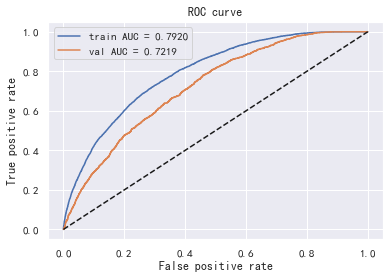

In [439]:
plot_ROC_AUC(dev_pre,val_pre)

In [441]:
import pickle
with open('./model/lgb-best.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

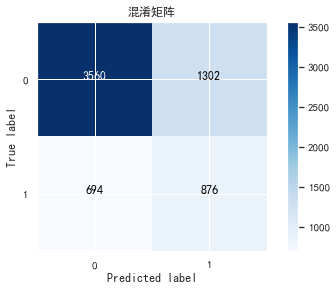

精确率: 0.402
召回率: 0.558
F1值: 0.467


In [442]:
other_zhibiao(val_pre)

In [ ]:
sns_p(bin_tr_1_ca,"./pic/lgb-best.png")

In [520]:
filename = "/pic/lgb-best-feature_im.png"
# 打印特征重要性
plt.figure(figsize=(1,100))
lgb.plot_importance(lgb_model,max_num_features=20)
plt.title("lgb模型特征重要性")
plt.savefig(filename,bbox_inches='tight')
plt.show()

TypeError: booster must be Booster or LGBMModel.

<Figure size 72x7200 with 0 Axes>

### xgb模型训练

In [374]:
import math
def solvePSI(model,dev_x,val_x,dev_y,val_y):
    train_matrix = xgb.DMatrix(dev_x , label=dev_y)
    valid_matrix = xgb.DMatrix(val_x , label=val_y)
    dev_predict_y = model.predict(train_matrix)
    dev_nrows = dev_x.shape[0]
    dev_predict_y.sort()
    # 等频分箱成10箱
    cutpoint = [100] + [dev_predict_y[int(dev_nrows/10*i)]for i in range(1,10)]+ [100]
    cutpoint = list(set(cutpoint))
    cutpoint.sort()
    val_predict_y = model.predict(valid_matrix)
    val_nrows = val_x.shape[0]
    PSI = 0
    # 计算每一个分箱的PSI
    for i in range(len(cutpoint) - 1):
        start_point ,end_point = cutpoint[i],cutpoint[i+1]
        dev_cnt = [p for p in dev_predict_y if start_point <= p < end_point]
        dev_ratio = len(dev_cnt) / dev_nrows + 1e-10
        val_cnt = [p for p in val_predict_y if start_point <= p < end_point]
        val_ratio = len(val_cnt) / val_nrows + 1e-10
        psi = (dev_ratio - val_ratio)*math.log(dev_ratio / val_ratio)
        PSI += psi
    return PSI

In [482]:
# off_data = data_tr_woe_guiyi[data_tr_woe_guiyi['using_time']==-0.826843]
# off_x = off_data[features]
# off_y = off_data['label']
# off_x_1 = selector_gb.transform(off_x)
# solvePSI(xgb_model,x_train_split,off_x_1,y_train_split,off_y)

In [418]:
# 相關性篩選
# RFE遞歸篩選
# PSI值和KS值筛选特征？

features = [f for f in data_tr_woe_guiyi.columns if f not in ['user','label']+DropFeature+['city','province']]
x_train = data_tr_woe_guiyi[features]
x_test = data_ts_woe_guiyi[features]
y_train = data_tr_woe_guiyi['label']

from sklearn.feature_selection import VarianceThreshold
selector_var = VarianceThreshold(threshold=3).fit(x_train,y_train)
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest,SelectFromModel
# #参数k为选择的特征个数
from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

# selector_pr = SelectKBest(k=15).fit(x_train,y_train)

selector_lr = SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit(x_train,y_train)
selector_gb = SelectFromModel(GradientBoostingClassifier()).fit(x_train,y_train)

In [388]:
x_train_1 = selector_gb.transform(x_train)
x_test_1 = selector_gb.transform(x_test)

In [524]:
# features = [f for f in data_tr_woe_1.columns if f not in ['user','label']+DropFeature+['city','province']]
# x_train = data_tr_woe_1[features]
# x_test = data_ts_woe_1[features]
# y_train = data_tr_woe_1['label']
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2)

train_matrix = xgb.DMatrix(x_train_split , label=y_train_split)
valid_matrix = xgb.DMatrix(x_val , label=y_val)
    
params = {'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'gamma': 1,
        'min_child_weight': 1.5,
        'max_depth': 5,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'colsample_bylevel': 0.7,
        'eta': 0.04,
        'tree_method': 'exact',
        'seed': 2020,
        'nthread': 36,
        "silent": True,
        'num_boost_round':50000, 
        'verbose_eval':3000, 'early_stopping_rounds':200
        }

watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]

# xgb_model = XGBClassifier(**test_params)

# xgb_model.fit(x_train_split,y_train_split)

xgb_model = xgb.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=3000, early_stopping_rounds=200)
dev_pre_xgb = xgb_model.predict(train_matrix,ntree_limit=xgb_model.best_ntree_limit)
val_pre_xgb = xgb_model.predict(valid_matrix, ntree_limit=xgb_model.best_ntree_limit)
# plot_ROC_AUC(dev_pre,val_pre,"xgb原始.png")

[03:42:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "early_stopping_rounds", "num_boost_round", "silent", "verbose_eval" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.66533	eval-auc:0.65109
[524]	train-auc:0.87377	eval-auc:0.70388


train_ks: 0.36510162155693404


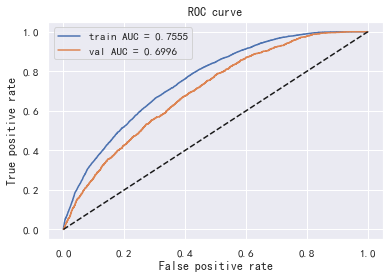

In [515]:
 plot_ROC_AUC(dev_pre_xgb,val_pre_xgb,None)

In [519]:
import pickle
with open('./model/xgb-best1.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

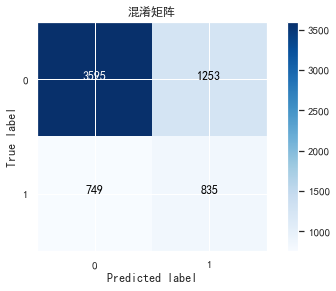

精确率: 0.400
召回率: 0.527
F1值: 0.455


In [447]:
other_zhibiao(val_pre_xgb)

In [523]:
# # select features using threshold
# selection = SelectFromModel(xgb_model, threshold=175, prefit=True)
# select_X_train = selection.transform(x_train)


<Figure size 72x7200 with 0 Axes>

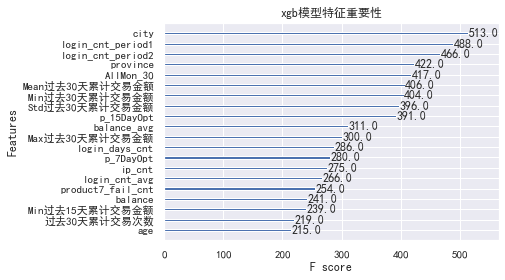

In [526]:
filename = "lgb-初筛-im.png"
# 打印特征重要性

plt.figure(figsize=(1,100))
xgb.plot_importance(xgb_model,max_num_features=20)
plt.title("xgb模型特征重要性")
# plt.savefig(filename,bbox_inches='tight')
plt.show()

### catboost

In [333]:
data_tr_2 = data_tr_1
data_ts_2 = data_ts_1

# 对sex/age/using_time进行分箱
all_co = data_tr_1.columns
ex_col = all_co.drop(['sex','age','using_time'])

import toad
from toad.plot import badrate_plot,bin_plot


combiner_1 = toad.transform.Combiner()
combiner_1.fit(data_tr_2,data_tr_2["label"],method='dt',exclude=ex_col)# 分箱

bin_tr_1_ca = combiner_1.transform(data_tr_2) 
bin_ts_1_ca =  combiner_1.transform(data_ts_2) 
# transer_1 = toad.transform.WOETransformer()
# data_tr_woe_1 = transer_1.fit_transform(bin_tr_1, bin_tr_1["label"],exclude=ex_col)
# data_ts_woe_1 = transer_1.transform(combiner_1.transform(data_ts_1))

In [321]:
features = [f for f in bin_tr_1.columns if f not in ['user','label']+DropFeature]
x_train = bin_tr_1[features]
x_test = bin_ts_1[features]
y_train = bin_tr_1['label']


In [322]:
from catboost import CatBoostRegressor,CatBoostClassifier
x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=1200)

params = {'depth': 8, 'eval_metric':'AUC','l2_leaf_reg': 10,
'random_strength':12,'one_hot_max_size':32,
'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}

cat_model = CatBoostRegressor(iterations=1000, **params)
cat_model.fit(x_train_split, y_train_split, eval_set=(x_val, y_val), cat_features=category_fea+['city','province'],use_best_model=True, verbose=500)

# grid = {'learning_rate': [0.03, 0.1],
#         'depth': [4, 6, 10],
#         'l2_leaf_reg': [1, 3, 5, 7, 9]}

# grid_search_result = cat_model.grid_search(grid,
#                                        X=x_train_split,
#                                        y=y_train_split,
#                                        plot=True)

# model = CatBoostRegressor(**params)
# model.fit(x_train_split,y_train_split,eval_set=(x_val, y_val),plot=True)  
    
dev_pred = cat_model.predict(x_train_split)
val_pred  = cat_model.predict(x_val)
test_pred = cat_model.predict(x_test)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	test: 0.5947879	best: 0.5947879 (0)	total: 47.2ms	remaining: 47.2s
500:	test: 0.7094177	best: 0.7094177 (500)	total: 22.4s	remaining: 22.3s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7118107526
bestIteration = 584

Shrink model to first 585 iterations.


train_ks: 0.42627866233655326


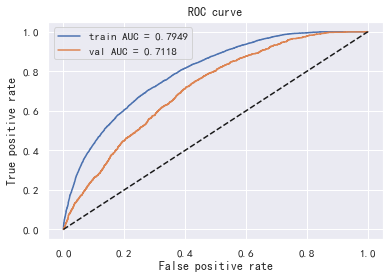

In [323]:
plot_ROC_AUC(dev_pred,val_pred)# 加入了city和province

train_ks: 0.42661240329334055


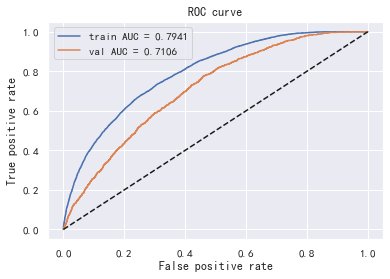

In [260]:
plot_ROC_AUC(dev_pred,val_pred)# 加入了city和province

In [328]:
cat_model.tree_count_

585

train_ks: 0.42627866233655326


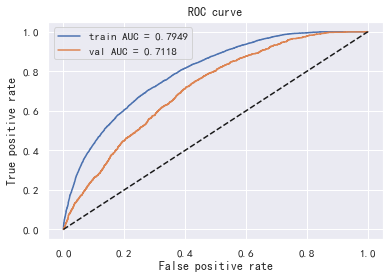

In [327]:
plot_ROC_AUC(dev_pred,val_pred)# 加入了city和province

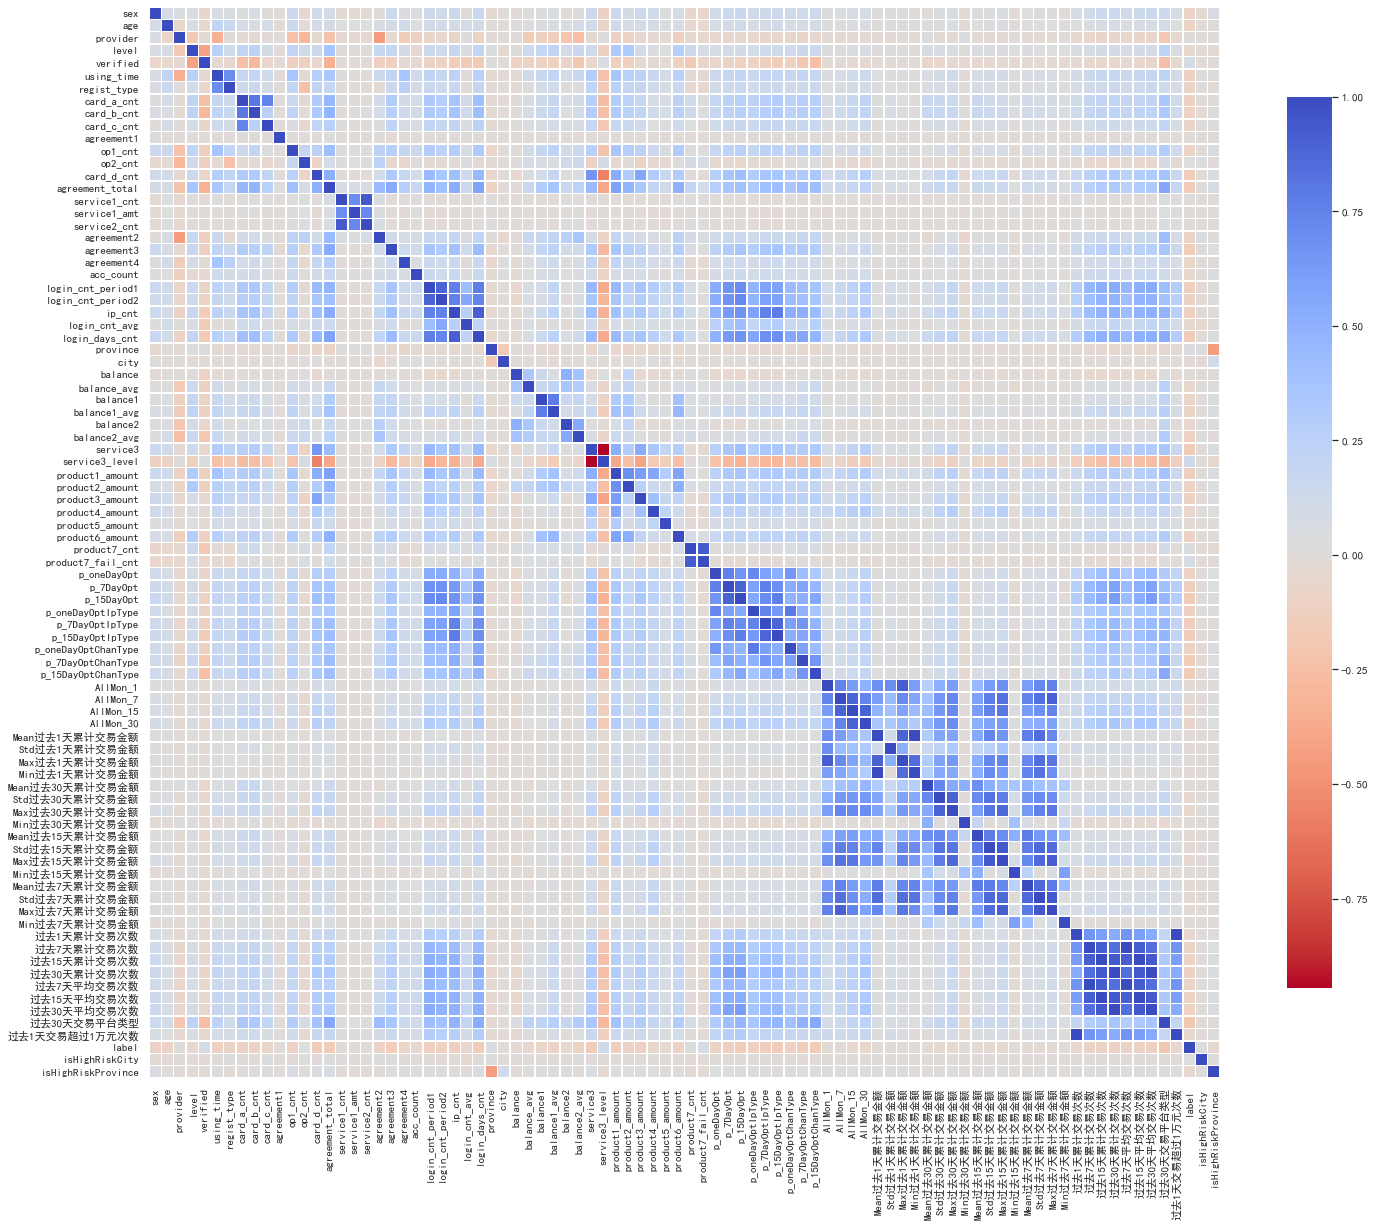

In [331]:
sns_p(bin_tr_1,"cat-1.png")

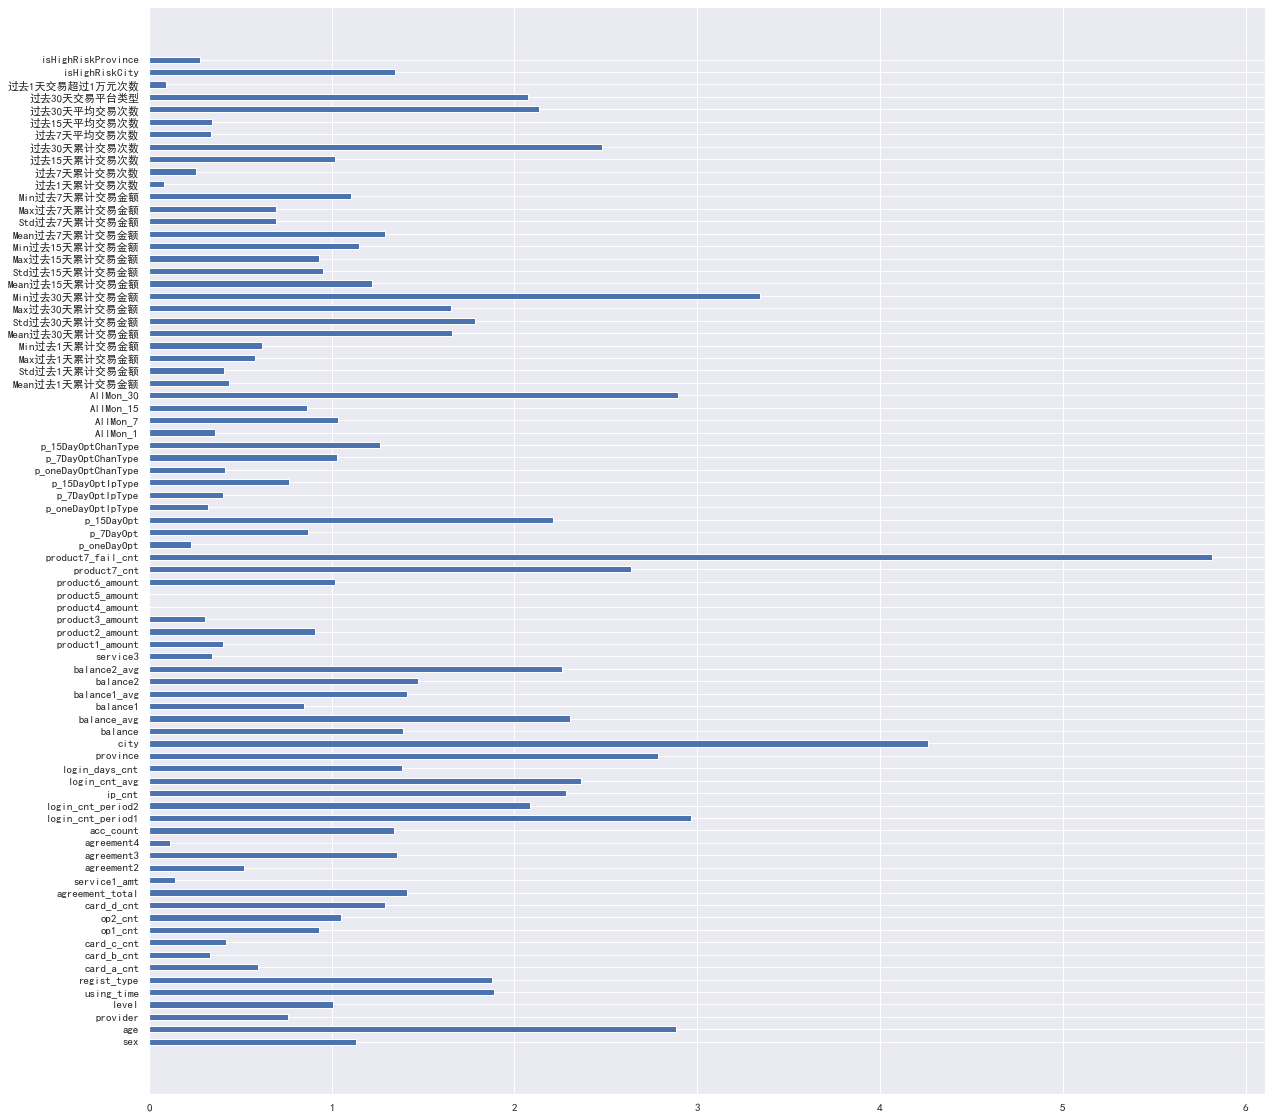

In [326]:
fea_ = cat_model.feature_importances_
fea_name = cat_model.feature_names_
plt.figure(figsize=(20, 20))
plt.barh(fea_name,fea_,height =0.5)
plt.savefig('./pic/catboost重要性.png',bbox_inches='tight')

<BarContainer object of 80 artists>

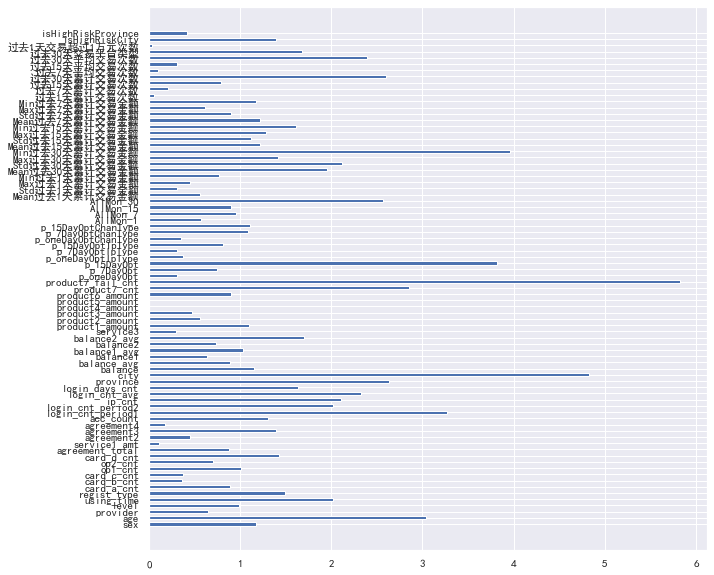

In [246]:
fea_ = cat_model.feature_importances_
fea_name = cat_model.feature_names_
plt.figure(figsize=(20, 20))
plt.barh(fea_name,fea_,height =0.5)

train_ks: 0.4446291570177461


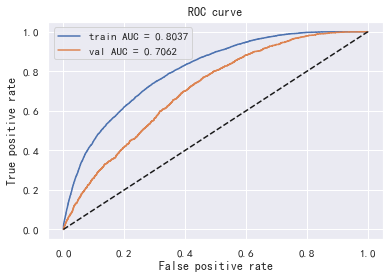

In [91]:
plot_ROC_AUC(dev_pred,val_pred)

<BarContainer object of 78 artists>

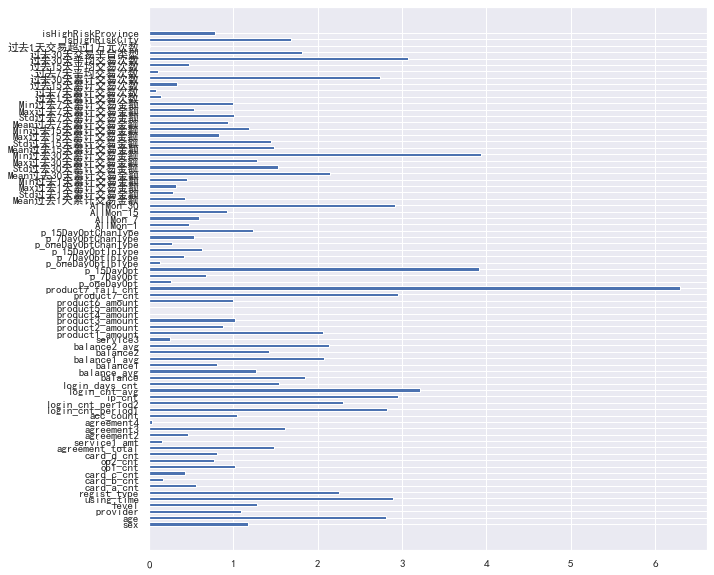

In [80]:
fea_ = cat_model.feature_importances_
fea_name = cat_model.feature_names_


plt.figure(figsize=(10, 10))
plt.barh(fea_name,fea_,height =0.5)

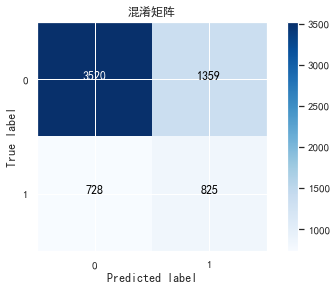

精确率: 0.378
召回率: 0.531
F1值: 0.442


In [156]:
other_zhibiao(val_pred)

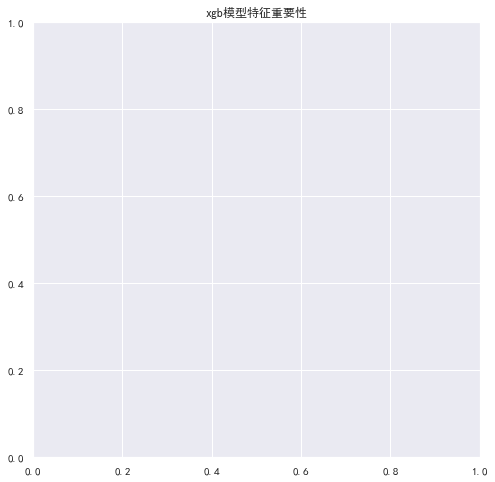

In [160]:
filename = "lgb-初筛-im.png"
# 打印特征重要性
plt.figure(figsize=(8,8))
cat_model.get_feature_importance()
plt.title("xgb模型特征重要性")
# plt.savefig(filename,bbox_inches='tight')
plt.show()

### 贝叶斯调参

In [356]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, x_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val

In [357]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

In [358]:

bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] bagging_fraction is set=0.64, subsample=1.0 will be ignored. Current value: bagging_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=87, subsample_freq=0 will be ignored. Current value: bagging_freq=87
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] 

In [364]:
bayes_lgb.max

{'target': 0.7111338097109139,
 'params': {'bagging_fraction': 0.73224808242657,
  'bagging_freq': 78.73749625074747,
  'feature_fraction': 0.5080472698655816,
  'max_depth': 5.648292872370708,
  'min_child_weight': 3.0528867756348523,
  'min_data_in_leaf': 87.26611687964964,
  'min_split_gain': 0.3800558503967437,
  'num_leaves': 177.3956217927106,
  'reg_alpha': 4.525607546192094,
  'reg_lambda': 8.439729376013272}}

### 整合

### 模型調參

### K折交叉驗證

In [507]:
def cv_model(clf, train_x, train_y, test_x, clf_name):
    folds = 8
    seed = 2020
    kf = KFold(n_splits=folds, shuffle=True, random_state=seed) # K折交叉验证

    train = np.zeros(train_x.shape[0])
    test = np.zeros(test_x.shape[0])

    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'learning_rate': 0.01,
                'num_leaves': 132,
                'max_depth': 5,
                'min_data_in_leaf': 16,
                'min_child_weight':9.4,
                'bagging_fraction': 0.73,
                'feature_fraction': 0.52,
                'bagging_freq': 25,
                'reg_lambda': 9,
                'reg_alpha': 8,
                'min_split_gain': 0.25,
                'nthread': 8,
                'seed': 2020,
                'silent': True,
                'verbose': -1,

                
            }

            model = clf.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=200,early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            # print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)

            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.04,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 36,
                      "silent": True,
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
                 
        if clf_name == "cat":
            params = {'learning_rate': 0.05, 'depth': 5, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
                      'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
            
            model = clf(iterations=20000, **params)
            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      cat_features=[], use_best_model=True, verbose=500)
            
            val_pred  = model.predict(val_x)
            test_pred = model.predict(test_x)
            
        train[valid_index] = val_pred
        test = test_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        
        print(cv_scores)
        
    print("%s_scotrainre_list:" % clf_name, cv_scores)
    print("%s_score_mean:" % clf_name, np.mean(cv_scores))
    print("%s_score_std:" % clf_name, np.std(cv_scores))
    return train, test

In [508]:
def lgb_model_k(x_train, y_train, x_test):
    lgb_train, lgb_test = cv_model(lgb, x_train, y_train, x_test, "lgb")
    return lgb_train, lgb_test

def xgb_model_k(x_train, y_train, x_test):
    xgb_train, xgb_test = cv_model(xgb, x_train, y_train, x_test, "xgb")
    return xgb_train, xgb_test

def cat_model_k(x_train, y_train, x_test):
    cat_train, cat_test = cv_model(CatBoostRegressor, x_train, y_train, x_test, "cat")

In [509]:
features = [f for f in bin_tr_1_ca.columns if f not in ['user','label']+DropFeature]
x_train = bin_tr_1_ca[features]
x_test = bin_ts_1_ca[features]
y_train = bin_tr_1_ca['label']

In [510]:
lgb_train, lgb_test = lgb_model_k(x_train, y_train, x_test)

************************************ 1 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.717462	valid_1's auc: 0.686029
[400]	training's auc: 0.732459	valid_1's auc: 0.695017
[600]	training's auc: 0.747523	valid_1's auc: 0.701379
[800]	training's auc: 0.758362	valid_1's auc: 0.70431
[1000]	training's auc: 0.769127	valid_1's auc: 0.706252
[1200]	training's auc: 0.777563	valid_1's auc: 0.708023
[1400]	training's auc: 0.785644	valid_1's auc: 0.708549
[1600]	training's auc: 0.793595	valid_1's auc: 0.708505
Early stopping, best iteration is:
[1498]	training's auc: 0.78943	valid_1's auc: 0.708788
[0.7087882976196541]
************************************ 2 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.71441	valid_1's auc: 0.706114
[400]	training's auc: 

### 模型融合

In [116]:

# 对sex/age/using_time进行分箱
all_co = data_tr_guiyi.columns
ex_col = all_co.drop(['sex','age','using_time'])

combiner_guiyi = toad.transform.Combiner()
combiner_guiyi.fit(data_tr_guiyi,data_tr_guiyi["label"],method='dt',exclude=ex_col)# 分箱

bin_tr_guiyi = combiner_guiyi.transform(data_tr_guiyi) 
bin_ts_guiyi =  combiner_guiyi.transform(data_ts_guiyi) 

transer_guiyi = toad.transform.WOETransformer()
data_tr_woe_guiyi = transer_guiyi.fit_transform(bin_tr_guiyi, bin_tr_guiyi["label"],exclude=ex_col)
data_ts_woe_guiyi = transer_guiyi.transform(transer_guiyi.transform(bin_ts_guiyi))

In [117]:
features = [f for f in data_tr_woe_guiyi.columns if f not in ['user','label']+DropFeature+['city','province']]
x_train = data_tr_woe_guiyi[features]
x_test = data_ts_woe_guiyi[features]
y_train = data_tr_woe_guiyi['label']

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2,random_state=1000)

In [494]:
from sklearn import metrics
import xgboost as xgb
import lightgbm as lgb

def xgb_model(X_train, y_train, X_test, y_test=None):

    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
    train_matrix = xgb.DMatrix(X_train_split , label=y_train_split)
    valid_matrix = xgb.DMatrix(X_val , label=y_val)
    test_matrix = xgb.DMatrix(X_test)

    params = {
        'booster': 'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'gamma': 1,
        'min_child_weight': 1.5,
        'max_depth': 5,
        'lambda': 10,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'colsample_bylevel': 0.7,
        'eta': 0.04,
        'tree_method': 'exact',
        'seed': 2020,
        'n_jobs': -1,
        "silent": True,
    }
    watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
    
    model = xgb.train(params, train_matrix, num_boost_round=50000, evals=watchlist, verbose_eval=200, early_stopping_rounds=200)
    """计算在验证集上的得分"""
    val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('xgboost单模型在验证集上的AUC：{}'.format(roc_auc))
    """对测试集进行预测"""
    test_pred = model.predict(test_matrix, ntree_limit=model.best_ntree_limit)
    
    return test_pred
    

def lgb_model(X_train, y_train, X_test, y_test=None):
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2)
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)
    
    # 调参后的最优参数
    params = {
    #    'boosting_type': 'gbdt',
    #     'objective': 'binary',
    #     'metric': 'auc',
    #     'learning_rate': 0.01,
    #     'num_leaves': 132,
    #     'max_depth': 5,
    #     'min_data_in_leaf': 16,
    #     'min_child_weight':9.4,
    #     'bagging_fraction': 0.73,
    #     'feature_fraction': 0.52,
    #     'bagging_freq': 25,
    #     'reg_lambda': 9,
    #     'reg_alpha': 8,
    #     'min_split_gain': 0.25,
    #     'nthread': 8,
    #     'seed': 2020,
    #     'silent': True,
    #     'verbose': -1,

        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': 132,
        'max_depth': 5,
        'min_data_in_leaf': 16,
        'min_child_weight':9.4,
        'bagging_fraction': 0.73,
        'feature_fraction': 0.52,
        'bagging_freq': 25,
        'reg_lambda': 9,
        'reg_alpha': 8,
        'min_split_gain': 0.25,
        'nthread': 8,
        'seed': 2020,
        'silent': True,
        'verbose': -1,
    }
    
    model = lgb.train(params, train_matrix, 50000, valid_sets=[train_matrix, valid_matrix], verbose_eval=500, early_stopping_rounds=500)
    """计算在验证集上的得分"""
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    fpr, tpr, threshold = metrics.roc_curve(y_val, val_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('调参后lightgbm单模型在验证集上的AUC：{}'.format(roc_auc))
    """对测试集进行预测"""
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)
    
    return test_pred

In [495]:
features = [f for f in data_tr_1.columns if f not in ['user','label']+DropFeature+['city','province']]
x_train = data_tr_1[features]
x_test = data_ts_1[features]
y_train = data_tr_1['label']

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2)


In [496]:
from heamy.dataset import Dataset
from heamy.estimator import Classifier

model_dataset = Dataset(X_train=x_train_split, y_train=y_train_split, X_test=x_val,y_test=y_val)
model_xgb = Classifier(dataset=model_dataset, estimator=xgb_model, name='xgb', use_cache=False)
model_lgb = Classifier(dataset=model_dataset, estimator=lgb_model, name='lgb', use_cache=False)

In [497]:
from heamy.pipeline import ModelsPipeline

pipeline = ModelsPipeline(model_xgb, model_lgb)
pipeline

In [498]:
stack_ds = pipeline.stack(k=5, seed=111, full_test=True)

[03:13:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-auc:0.66408	eval-auc:0.65260
[200]	train-auc:0.79839	eval-auc:0.70230
[400]	train-auc:0.85406	eval-auc:0.70374
[445]	train-auc:0.86399	eval-auc:0.70339
xgboost单模型在验证集上的AUC：0.7047257968807302
[03:13:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue

In [499]:
from sklearn.linear_model import LogisticRegression
# 第二层使用逻辑回归进行stack
LogisticRegression(solver='lbfgs')
stacker = Classifier(dataset=stack_ds, estimator=LogisticRegression, parameters={'solver': 'lbfgs'})
# 测试集的预测结果
# test_pred = stacker.predict()
# test_pred

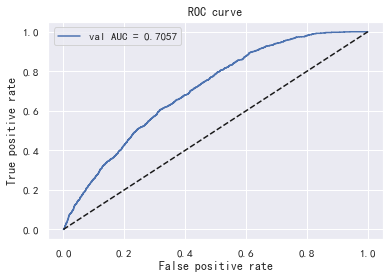

In [500]:
y_pred_slf = stacker.predict()
# plot_ROC_AUC(val_pre=y_pred_slf)
fpr_lr_val,tpr_lr_val , _ = roc_curve(y_val,y_pred_slf)
val_roc_auc = metrics.auc(fpr_lr_val, tpr_lr_val)
plt.plot(fpr_lr_val,tpr_lr_val,label = 'val AUC = %0.4f' % val_roc_auc)

plt.plot([0,1],[0,1],'k--')
# plt.plot([0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
# if filename:
#     plt.savefig(filename,bbox_inches='tight')
plt.show()

In [122]:
lgb_params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.05,
            'num_leaves': 95,
            'max_depth': 3,
            'min_data_in_leaf': 43,
            'min_child_weight':9.5,
            'bagging_fraction': 0.98,
            'feature_fraction': 0.96,
            'bagging_freq': 42,
            'reg_lambda': 8,
            'reg_alpha': 4,
            'min_split_gain': 0.25,
            'nthread': 8,
            'seed': 2020,
}
xgb_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'gamma': 1,
    'min_child_weight': 1.5,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'colsample_bylevel': 0.7,
    'eta': 0.04,
    'tree_method': 'exact',
    'seed': 2020,
    'nthread': 36,
}
cat_params = {'learning_rate': 0.05, 'depth': 8, 'eval_metric':'AUC','l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}



In [433]:
# features = [f for f in .columns if f not in ['user','label']+DropFeature+['city','province']]
# x_train = data_tr_1[features]
# x_test = data_ts_1[features]
# y_train = data_tr_1['label']

x_train_split, x_val, y_train_split, y_val = train_test_split(x_train_1, y_train, test_size=0.2)

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
# clf1 = LogisticRegression(random_state=1)
# clf1 = RandomForestClassifier(random_state=1)
clf1 = lgb.LGBMClassifier(**lgb_params)
clf2 = xgb.XGBClassifier(**xgb_params)
# clf3 = RandomForestClassifier(n_estimators=50, max_depth=1, min_samples_split=4,
#                               min_samples_leaf=63,oob_score=True)
# clf2 = cbr(**cat_params)

vclf = VotingClassifier(estimators=[('lgb', clf1), ('xgb', clf2)],voting='soft',weights=[2,1])

vclf = vclf.fit(x_train_split,y_train_split)

val_pred_vl = vclf.predict(x_val)
dev_pred_vl = vclf.predict(x_train_split)

# print(vclf.predict(x_train_split))

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=8 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] bagging_freq is set=42, subsample_freq=0 will be ignored. Current value: bagging_freq=42


train_ks: 0.004628230171275666


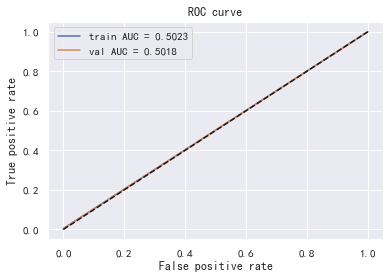

In [434]:
fpr_lr_train,tpr_lr_train , _ = roc_curve(y_train_split,dev_pred_vl)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print("train_ks:",train_ks)
dev_roc_auc = metrics.auc(fpr_lr_train, tpr_lr_train)
plt.plot(fpr_lr_train,tpr_lr_train, label = 'train AUC = %0.4f' % dev_roc_auc)
fpr_lr_val,tpr_lr_val , _ = roc_curve(y_val,val_pred_vl)
val_roc_auc = metrics.auc(fpr_lr_val, tpr_lr_val)
plt.plot(fpr_lr_val,tpr_lr_val,label = 'val AUC = %0.4f' % val_roc_auc)
plt.plot([0,1],[0,1],'k--')
# plt.plot([0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
# if filename:
#     plt.savefig(filename,bbox_inches='tight')
plt.show()

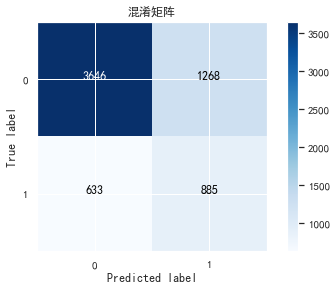

精确率: 0.411
召回率: 0.583
F1值: 0.482


In [162]:
other_zhibiao(val_pred_vl)

In [134]:
from catboost import  CatBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
#模型融合中基学习器
clfs = [xgb.XGBClassifier(**xgb_params),
        lgb.LGBMClassifier(**lgb_params)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(x_train, y_train, test_size=0.3, random_state=2020)


#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=914)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict(X_d2)
    # y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:,j] = clf.predict(X_predict)
    # dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))


#融合使用的模型
clf = GradientBoostingClassifier()
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict(dataset_d2)
# y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

[20:32:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


val auc Score: 0.510247
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=8 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.96, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.96
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] bagging_freq is set=42, subsample_freq=0 will be ignored. Cu

### 模型評價

In [66]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix"', cmap=plt.cm.Blues,saveFile="混淆矩阵.png"):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(saveFile,bbox_inches='tight')
    plt.show()
    

    
# 显示模型评估结果
def show_metrics(cm):
    tp = cm[1, 1]
    fn = cm[1, 0]
    fp = cm[0, 1]
    tn = cm[0, 0]
    precision = tp / (tp + fp)
    recall= tp / (tp + fn)
    f1 = 2 * (((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp)) + (tp / (tp + fn))))
    print('精确率: {:.3f}'.format(tp / (tp + fp)))
    print('召回率: {:.3f}'.format(tp / (tp + fn)))
    print('F1值: {:.3f}'.format(2 * (((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp)) + (tp / (tp + fn))))))
    return precision,recall,f1

# 绘制精确率-召回率曲线
def plot_precision_recall(recall,precision,saveFile="精确率-召回率曲线"):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
    plt.plot(recall, precision, linewidth=2)
    plt.xlim([0.0, 1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('召回率')
    plt.ylabel('精确率')
    plt.title('精确率-召回率 曲线')
    plt.show()
    plt.savefig(saveFile,bbox_inches='tight')
    

In [191]:
from sklearn import  metrics

def plot_ROC_AUC(dev_pre=None,val_pre=None,filename=None):
    if dev_pre is not None:
        fpr_lr_train,tpr_lr_train , _ = roc_curve(y_train_split,dev_pre)
        train_ks = abs(fpr_lr_train - tpr_lr_train).max()
        print("train_ks:",train_ks)
        dev_roc_auc = metrics.auc(fpr_lr_train, tpr_lr_train)
        plt.plot(fpr_lr_train,tpr_lr_train, label = 'train AUC = %0.4f' % dev_roc_auc)
    if val_pre is not None:
        fpr_lr_val,tpr_lr_val , _ = roc_curve(y_val,val_pre)
        val_roc_auc = metrics.auc(fpr_lr_val, tpr_lr_val)
        plt.plot(fpr_lr_val,tpr_lr_val,label = 'val AUC = %0.4f' % val_roc_auc)
    
    plt.plot([0,1],[0,1],'k--')
    # plt.plot([0,1],'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc = 'best')
    if filename:
        plt.savefig(filename,bbox_inches='tight')
    plt.show()

In [68]:
from sklearn.metrics import confusion_matrix
def other_zhibiao(val_pre):
    y_pred_binary = (val_pre >= 0.3)*1
    # # 计算混淆矩阵，并显示
    cm = confusion_matrix(y_val,y_pred_binary)
    class_names = [0, 1]
    # 显示混淆矩阵
    plot_confusion_matrix(cm, classes=class_names, title='混淆矩阵')
    # 显示模型评估分数
    precision, recall,f1 = show_metrics(cm)
    # 计算精确率，召回率，阈值用于可视化
    # precision, recall, thresholds = precision_recall_curve(y_pred_binary, score_y)
    # plot_precision_recall(recall,precision)